In [1]:
from ssm.models import SLDS
from ssm.emissions import GaussianIdentityEmissions
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
import numpy as np
import scipy.io
from pybasicbayes.util.text import progprint_xrange
import matplotlib.pyplot as plt
from ssm.util import random_rotation, find_permutation
import pandas as pd

In [2]:
N_array = np.array([10,14,18,20,30,50,80,100,200,400,1000,2000,4000])
Kmax = 4
table_file = "comparison_output_rank4.csv"
output_file = "comparison_final_rank4.csv"

In [3]:
def fit_slds_and_return_errors(X, A1, A2, Kmax=2, r=6, num_iters=2000):
    '''
    Fit an SLDS to test data and return errors.
    
    Parameters
    ==========
    
    X : array, T x N
    A1 : array, N x N
    A2 : array, N x N
    '''
    from numpy.linalg import norm
    # params
    N = X.shape[1]
    T = X.shape[0]
    # fit a model
    slds = SLDS(N, Kmax, r)
    slds.initialize(X)
    q_mf = SLDSMeanFieldVariationalPosterior(slds, X)
    q_mf_elbos = slds.fit(q_mf, X, num_iters=num_iters, initialize=False)
    q_mf_x = q_mf.mean[0]
    # predict states
    true_states = np.array([0 if i < T/2 else 1 for i in range(T)])
    slds.permute(find_permutation(true_states, slds.most_likely_states(q_mf_x, X), 2, Kmax))
    pred_states = slds.most_likely_states(q_mf_x, X)
    print("predicted states:")
    print(pred_states)
    # extract predicted A1, A2 matrices
    A_r = slds.dynamics.As
    b_r = slds.dynamics.bs
    Cs = slds.emissions.Cs[0]
    A1_pred = Cs @ A_r[0] @ np.linalg.pinv(Cs)
    A2_pred = Cs @ A_r[1] @ np.linalg.pinv(Cs)
    # compare inferred and true
    #err_inf = 0.5 * (np.max(np.abs(A1_pred[:] - A1[:])) + \
    #                 np.max(np.abs(A2_pred[:] - A2[:])))
    #err_2 = 0.5 * (norm(A1_pred - A1, 2) + \
    #               norm(A2_pred - A2, 2))
    #err_fro = 0.5 * (norm(A1_pred - A1, 'fro') + \
    #                 norm(A2_pred - A2, 'fro'))
    err_mse = 0.
    err_inf = 0.
    err_2 = 0.
    err_fro = 0.
    for t in range(T-1):
        if true_states[t] == 0:
            A_true = A1
        else:
            A_true = A2
        A_r = slds.dynamics.As[pred_states[t]]
        A_pred = Cs @ A_r @ np.linalg.pinv(Cs)
        xpred = A_pred @ X[t, :].T + Cs @ b_r[pred_states[t]]
        err_mse += norm(xpred - X[t+1, :], 2)**2
        err_inf += np.max(np.abs(A_pred[:] - A_true[:]))
        err_2 += norm(A_pred - A_true, 2)
        err_fro += norm(A_pred - A_true, 'fro')
    err_mse /= float(N * (T - 1))
    err_inf /= float(T - 1)
    err_2 /= float(T - 1)
    err_fro /= float(T - 1)
    return (err_inf, err_2, err_fro, err_mse)

In [4]:
error_table = pd.read_csv(table_file)
print(error_table.tail())
print(error_table.columns)
#error_table = pd.DataFrame(columns = ['N', 'window', 'model', 'err_inf', 'err_2', 'err_fro', 'model_MSE', \
#                    'true_MSE'])

        N  window  model   err_inf     err_2   err_fro  model_MSE  true_MSE
415  4000       6      3  0.000376  0.172589  0.226581   0.245629  0.249769
416  4000       7      3  0.000381  0.174823  0.226544   0.248406  0.252503
417  4000       8      3  0.000376  0.172915  0.226601   0.246242  0.250254
418  4000       9      3  0.000385  0.177674  0.230353   0.248455  0.252598
419  4000      10      3  0.000377  0.172579  0.225419   0.243832  0.247662
Index(['N', 'window', 'model', 'err_inf', 'err_2', 'err_fro', 'model_MSE',
       'true_MSE'],
      dtype='object')


## Fit SLDS with rank r = 4 & r = 6

In [5]:
for N in N_array:
    data = scipy.io.loadmat("test_data_N_%d_M_221_sigma_0.500000.mat" % N)
    X = data['X']
    A1 = data['A1']
    A2 = data['A2']
    err_inf, err_2, err_fro, err_mse = \
        fit_slds_and_return_errors(X.T, A1, A2, Kmax=Kmax, r=4, num_iters=6000)
    print("N = %d : err_inf = %f, err_2 = %f, err_fro = %f, err_mse = %f" % \
           (N, err_inf, err_2, err_fro, err_mse))

    new_row = dict(zip(error_table.columns, 
                       [N, np.nan, 4, err_inf, err_2, err_fro, err_mse, np.nan]))
    error_table = error_table.append(new_row, ignore_index=True)

Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 1 1 3 1 1 1 1 1 1 2 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 1 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1]
N = 10 : err_inf = 0.428528, err_2 = 1.430425, err_fro = 1.622371, err_mse = 0.374216
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 3 3 3 3 3 1 3 3 3 1 3 3 3 3 3 3 1 1 1 1 1 3 1 1 1 1 1 1 1 3 3 3 3 3
 1 1 1 1 1 3 3 3 3 3 3 3 1 1 1 1 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 3 3 3 3 3 3 3 3]
N = 14 : err_inf = 0.065992, err_2 = 0.234048, err_fro = 0.288027, err_mse = 0.290995
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
N = 18 : err_inf = 0.065438, err_2 = 0.257458, err_fro = 0.307582, err_mse = 0.278477
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 1 1 1 1 1 1 1 1 1 3 0 0 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 20 : err_inf = 0.284119, err_2 = 1.343583, err_fro = 1.563726, err_mse = 0.304771
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 1 1 1 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1
 1 1 1 1 2 2 2 2 3 3 3 1 1 1 1 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1]
N = 30 : err_inf = 0.035849, err_2 = 0.235153, err_fro = 0.291670, err_mse = 0.268157
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 2 3 3 3 3 1 1]
N = 50 : err_inf = 0.046023, err_2 = 0.443306, err_fro = 0.495346, err_mse = 0.264189
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 80 : err_inf = 0.022933, err_2 = 0.360783, err_fro = 0.410742, err_mse = 0.261548
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1
 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 2 1 1 1]
N = 100 : err_inf = 0.030934, err_2 = 0.451506, err_fro = 0.522681, err_mse = 0.260415
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 3 3 1 1 1 2 2 1 1 1 3 3 3 3 3 2 3 3 3 3 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 2
 2 2 1 1 1 1 3 3 3 3 2 2 2 2 3 3 3 3 1 1 3 3 3 2 2 2 1 1 1 1 1 1 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 3 3 3 1 1 1 1 1 2 1 1]
N = 200 : err_inf = 0.013481, err_2 = 0.414104, err_fro = 0.469746, err_mse = 0.256545
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 2 3 3 3 1 1 1 2 3 1 1 1 1 2 2 3 1 1 1 2 2 2 3 1 2 2 3 1 1 1 2 3 1 2 2 2 3
 1 1 1 2 3 3 1 1 1 1 1 2 3 1 2 3 3 3 1 2 2 3 1 1 1 1 1 1 1 2 3 1 2 3 1 1 2
 2 3 1 1 1 2 2 3 1 1 2 3 3 1 1 2 3 3 1 1 2 2 3 3 3 1 2 3 1 2 3 3 1 2 3 3]
N = 400 : err_inf = 0.006594, err_2 = 0.405371, err_fro = 0.472090, err_mse = 0.253078
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 1000 : err_inf = 0.005551, err_2 = 0.691464, err_fro = 0.810780, err_mse = 0.252587
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 2000 : err_inf = 0.000872, err_2 = 0.226636, err_fro = 0.299721, err_mse = 0.252420
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]
N = 4000 : err_inf = 0.001374, err_2 = 0.792397, err_fro = 0.828884, err_mse = 0.252377


In [6]:
for N in N_array[N_array > 6]:
    data = scipy.io.loadmat("test_data_N_%d_M_221_sigma_0.500000.mat" % N)
    X = data['X']
    A1 = data['A1']
    A2 = data['A2']
    err_inf, err_2, err_fro, err_mse = \
        fit_slds_and_return_errors(X.T, A1, A2, Kmax=Kmax, r=6, num_iters=6000)
    print("N = %d : err_inf = %f, err_2 = %f, err_fro = %f, err_mse = %f" % \
           (N, err_inf, err_2, err_fro, err_mse))
    new_row = dict(zip(error_table.columns, 
                       [N, np.nan, 5, err_inf, err_2, err_fro, err_mse, np.nan]))
    error_table = error_table.append(new_row, ignore_index=True)

Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[1 1 1 1 1 2 2 2 2 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 1 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 3 1 1 1 1 1 2 2 2 2 2 0 0 0 0 0 0 0 0 3 3 3 3 1 1 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 3 3 1 2 3 3 3 1 1 1 2 2 0 0 0 0 0 0 3 3 3 3 3 3 1 1 1 2 1 2 2 2
 3 1 1 1 2 3 3 1 1 1 2 0 3 1 2 2 0 3 1 1 2 3 3 3 1 2 2 0 3 1 2 0 0 0 3 1 1
 2 2 0 3 1 2 3 1 1 2 2 0 3 1 2 2 0 3 1 1 2 2 2 0 3 1 0 3 3 3 1 2 2 0 0 3 1
 2 2 1 1 1 2 0 0 3 1 2 2 0 0 3 1 2 0 3 1 1 1 2 0 0 3 1 2 2 3 3 1 2 2 0 3]
N = 10 : err_inf = 0.613705, err_2 = 1.665900, err_fro = 1.997882, err_mse = 0.431796
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 3 3 2 3 0 0 0 0 0 0 0 0 0 0 2 3 3 3 3 3 0 0 0 0 0 0 0 0 2 1
 2 2 2 3 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 2 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 2 3 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 3 1 2 1 1 2 1 1]
N = 14 : err_inf = 0.319856, err_2 = 0.882232, err_fro = 1.082329, err_mse = 0.330366
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 1 1 1 3 3 3 3 3 3 2 2 2 0 0 0 0 0 0 0 0 1 1 3 3 3 3 3 3 3 2 2
 2 2 0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 0 0 0 1 1 3 3 3 3 3 3
 2 2 2 2 2 2 2 2 0 0 0 0 1 1 3 3 3 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1
 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 2 2 2]
N = 18 : err_inf = 0.531988, err_2 = 1.795729, err_fro = 2.216397, err_mse = 0.339366
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 2 2 2 2 2 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 3 3 3 0 0 0 0
 0 0 0 0 0 0 0 0 2 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 2 3 3 3 3 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 3 3 0 0 0 0 0 0 0 2 2 2 2 2 0 2 2 2 2 1
 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 20 : err_inf = 0.290636, err_2 = 0.963147, err_fro = 1.154462, err_mse = 0.292827
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 0 0 0 0 0 0 0 0 1 1 2 2 2 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 1 1 2 2 1
 1 2 2 1 1 1 0 0 0 0 0 0 0 0 0 1 1 3 3 3 2 1 1 1 1 1 1 2 2 2 0 0 0 0 0 1 1
 3 3 3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 1 2 2 2 0 0 0 0 0 0 1 3
 2 2 2 2 1 3 3 3 2 1 1 1 2 2 1 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 3 2 2 2 2
 2 2 1 1 1 1 1 2 2 2 1 1 3 2 2 1 1 3 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 3 3 2
 2 2 1 1 1 1 1 1 2 2 2 1 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3]
N = 30 : err_inf = 0.301253, err_2 = 1.572853, err_fro = 1.825020, err_mse = 0.301615
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 2 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3 2 2 2 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 2 2 2 2 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 0 0 0 0 0 0 3 3 3 3 3 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 3 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 2 2 2 1 1 1 1 1 1 2 2 2 1 1 1 1]
N = 50 : err_inf = 0.214469, err_2 = 1.611541, err_fro = 1.804908, err_mse = 0.274087
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 3
 3 3 3 3 3 3 2 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 2 0 0 0 0 0 0 0 3 1
 2 2 2 1 1 1 1 1 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 2 2 1 1 1 1 1
 1 1 1 1 1 3 3 3 1 1 1 2 1 1 1 1 1 1 1 1 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 3 3 3 3 3 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
N = 80 : err_inf = 0.084906, err_2 = 1.122425, err_fro = 1.259504, err_mse = 0.262335
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 2 3
 1 1 1 2 2 2 3 3 3 3 1 1 1 1 1 1 1 3 3 3 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1
 2 3 3 3 3 3 3 3 1 1 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3
 3 1 1 1 1 3 2 3 3 3 3 3 2 2 3 3 3 3 3 3 1 1 1 1 1 3 3 3 3 3 3 3 3 1 1 1]
N = 100 : err_inf = 0.066666, err_2 = 0.998366, err_fro = 1.244837, err_mse = 0.263803
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 2 3 2 3 1 1 2 2 1
 2 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 2 1 1 2 3 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 2
 3 3 1 1 1 1 2 1 1 1 1 1 1 1 2 3 2 1 1 1 1 3 1 2 1 1 1 3 3 2 2 1 1 1 1 1]
N = 200 : err_inf = 0.029529, err_2 = 0.812384, err_fro = 0.973991, err_mse = 0.261609
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 3 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 3 3 1 1 3 3]
N = 400 : err_inf = 0.030095, err_2 = 1.240009, err_fro = 1.473037, err_mse = 0.260342
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 2 2 2 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 3 3 3 1 2 2 1 2 1 2 1 2 2 1 1 2 2 2
 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1]
N = 1000 : err_inf = 0.010043, err_2 = 0.979333, err_fro = 1.122901, err_mse = 0.253482
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2
 2 2 2 2 2 2 2 1 1 1 2 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1]
N = 2000 : err_inf = 0.007881, err_2 = 1.604557, err_fro = 1.830306, err_mse = 0.252237
Initializing with an ARHMM using 25 steps of EM.


/home/kamdh/local/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]



predicted states:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1
 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 3 3 3 1 1 1 1 3 1 1 1 1 1 1 1
 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1]
N = 4000 : err_inf = 0.003626, err_2 = 1.289425, err_fro = 1.422682, err_mse = 0.252862


In [7]:
error_table.tail()

,N,window,model,err_inf,err_2,err_fro,model_MSE,true_MSE
441,200.0,NaN,5.0,0.029529,0.812384,0.973991,0.261609,NaN
442,400.0,NaN,5.0,0.030095,1.240009,1.473037,0.260342,NaN
443,1000.0,NaN,5.0,0.010043,0.979333,1.122901,0.253482,NaN
444,2000.0,NaN,5.0,0.007881,1.604557,1.830306,0.252237,NaN
445,4000.0,NaN,5.0,0.003626,1.289425,1.422682,0.252862,NaN


In [ ]:
data = error_table
#plt.loglog(data['N'], data['err_2'])
fig, ax = plt.subplots()

for key, grp in data.groupby(['model']):
    grp = grp.groupby(['N']).mean()
    if key == 1:
        keystr = 'indep(N)'
    elif key == 2:
        keystr = 'indep(4)'
    elif key == 3:
        keystr = 'TVART(4)'
    elif key == 4:
        keystr = 'SLDS(4)'
    elif key == 5:
        keystr = 'SLDS(6)'
    ax = grp.plot(ax=ax, kind='line', y='err_fro', label=keystr, logx=True, logy=True)

plt.legend(loc='best')
#plt.ylim([1e-2, 1e-1])
plt.show()

#data.plot.line(x='N', y='err_inf', logx=True, logy=True)

In [9]:
error_table.tail()

,N,window,model,err_inf,err_2,err_fro,model_MSE,true_MSE
441,200.0,NaN,5.0,0.029529,0.812384,0.973991,0.261609,NaN
442,400.0,NaN,5.0,0.030095,1.240009,1.473037,0.260342,NaN
443,1000.0,NaN,5.0,0.010043,0.979333,1.122901,0.253482,NaN
444,2000.0,NaN,5.0,0.007881,1.604557,1.830306,0.252237,NaN
445,4000.0,NaN,5.0,0.003626,1.289425,1.422682,0.252862,NaN


In [10]:
error_table.to_csv(output_file, header=True, index=False)

In [11]:
norm_vector = np.zeros((len(N_array), 3))
for i, N in enumerate(N_array):
    data = scipy.io.loadmat("test_data_N_%d_M_221_sigma_0.500000.mat" % N)
    X = data['X']
    A1 = data['A1']
    A2 = data['A2']
    norm_vector[i, 0] = 0.5 * (np.max(np.abs(A1.ravel())) +  np.max(np.abs(A2.ravel())))
    norm_vector[i, 1] = 0.5 * (np.linalg.norm(A1, 2) +  np.linalg.norm(A2, 2))
    norm_vector[i, 2] = 0.5 * (np.linalg.norm(A1, 'fro') +  np.linalg.norm(A2, 'fro'))

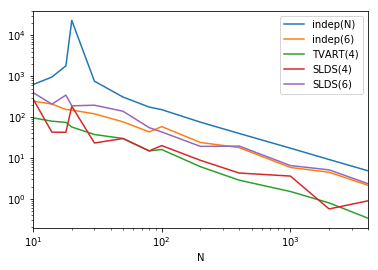

In [12]:
data = error_table
#plt.loglog(data['N'], data['err_2'])
fig, ax = plt.subplots()

for key, grp in data.groupby(['model']):
    grp = grp.groupby(['N']).mean()
    if key == 1:
        keystr = 'indep(N)'
    elif key == 2:
        keystr = 'indep(6)'
    elif key == 3:
        keystr = 'TVART(4)'
    elif key == 4:
        keystr = 'SLDS(4)'
    elif key == 5:
        keystr = 'SLDS(6)'
    grp = grp.iloc[grp.index >= min(N_array)]
    grp['err_inf'] /= norm_vector[i, 0]
    grp['err_2']   /= norm_vector[i, 1]
    grp['err_fro'] /= norm_vector[i, 2]
    ax = grp.plot(ax=ax, kind='line', y='err_inf', label=keystr, logx=True, logy=True)

plt.legend(loc='best')
#plt.ylim([1e-2, 1e-1])
plt.show()


In [13]:
X.shape

(4000, 221)

In [14]:
grp

,window,model,err_inf,err_2,err_fro,model_MSE,true_MSE
N,,,,,,,
10.0,NaN,5.0,398.774595,1.665900,1.412716,0.431796,NaN
14.0,NaN,5.0,207.836386,0.882232,0.765322,0.330366,NaN
18.0,NaN,5.0,345.676058,1.795729,1.567229,0.339366,NaN
20.0,NaN,5.0,188.849949,0.963147,0.816328,0.292827,NaN
30.0,NaN,5.0,195.748428,1.572853,1.290484,0.301615,NaN
50.0,NaN,5.0,139.358157,1.611541,1.276263,0.274087,NaN
80.0,NaN,5.0,55.170238,1.122425,0.890604,0.262335,NaN
100.0,NaN,5.0,43.318060,0.998366,0.880233,0.263803,NaN
200.0,NaN,5.0,19.187131,0.812384,0.688716,0.261609,NaN


In [15]:
output_file = "comparison_final_rank4.csv"
error_table.to_csv(output_file, header=True, index=False)

In [ ]:
error_table_2 = pd.read_csv("comparison_output_rank6.csv")